# Lab 10 - Linear Models

In [1]:
% matplotlib inline

## Directions

**Failure to follow the directions will result in a "0"**

The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN605.448@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

### General Instructions

1.  You will be submitting your assignment to Blackboard. If there are no accompanying files, you should submit *only* your notebook and it should be named using *only* your JHED id: fsmith79.ipynb for example if your JHED id were "fsmith79". If the assignment requires additional files, you should name the *folder/directory* your JHED id and put all items in that folder/directory, ZIP it up (only ZIP...no other compression), and submit it to Blackboard.
    
    * do **not** use absolute paths in your notebooks. All resources should appear in the same directory as the rest of your assignments.
    * the directory **must** be named your JHED id and **only** your JHED id.
    
2. Data Science is as much about what you write (communicating) as the code you execute (researching). In many places, you will be required to execute code and discuss both the purpose and the result. Additionally, Data Science is about reproducibility and transparency. This includes good communication with your team and possibly with yourself. Therefore, you must show **all** work.

3. Avail yourself of the Markdown/Codecell nature of the notebook. If you don't know about Markdown, look it up. Your notebooks should not look like ransom notes. Don't make everything bold. Clearly indicate what question you are answering.

4. Submit a cleanly executed notebook. It should say `In [1]` for the first codecell and increase by 1 throughout.

## Linear Regression

In a previous module (Lab 5), you performed EDA on the insurance data set. In this Lab, you should build a linear regression model trying to estimate `charges`.

In [2]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import models
import statsmodels.api as sm

sns.set(style="whitegrid")

# Answer

In [3]:
insurance = pd.read_csv( "insurance.csv")

Let's review the data from Lab 5 prior to going into building the model.

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [5]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We have seven variables. Age, sex, BMI, children, smoker, region, and our target variable, charges. I had investigated the relationship of most of the variables with charges in Lab 5 so I will pull the relationships here. While the others I hadn't investigated in Lab 5 I will make an estimation as to how they contribute to charges.

**Age**: Positive - I expect younger people to have fewer charges due to better health and less time and opportunity to pay.

**Sex**: None (maybe positive) - Since sex is categorical we will have one variable denoting 1 if male and 0 if not. My Lab 5 investigation showed they were pretty evenly distributed with charges but males had a larger IQR. So male may have a positive affect.

**BMI**: Positive - Lab 5 showed little correlation between the two but more variation as BMI increased. I also expect BMI to result in higher charges as higher BMI means more health concerns.

**Children**: Positive - I expect the more children to mean higher charges. However, with my investigation in Lab 5, there were very few data points for families with 4 or 5 children.

**Smoker**: Positive - From both Lab 5 and intuition being a smoker will have a large positive impact on charges.

**Region**: We'll have three variables for region, NE, NW, SE, and then if none of those have a value of 1 then it represents SW. I didn't investigate the region's affect on charges in Lab 5 so there may be some kind of relationship given the region but my intuition says there is not.

### Dummy Variable Creation

We need to create dummy variables for Sex, Smoker, and Region.

In [6]:
insurance["sex"].head()

0    female
1      male
2      male
3      male
4      male
Name: sex, dtype: object

In [7]:
insurance["sex"] = insurance.sex.apply(lambda x: 1 if x == 'male' else 0)

In [8]:
insurance["sex"].head()

0    0
1    1
2    1
3    1
4    1
Name: sex, dtype: int64

In [9]:
insurance["smoker"].head()

0    yes
1     no
2     no
3     no
4     no
Name: smoker, dtype: object

In [10]:
insurance["smoker"] = insurance.smoker.apply(lambda x: 1 if x == 'yes' else 0)

In [11]:
insurance["smoker"].head()

0    1
1    0
2    0
3    0
4    0
Name: smoker, dtype: int64

In [12]:
insurance["region"].head()

0    southwest
1    southeast
2    southeast
3    northwest
4    northwest
Name: region, dtype: object

In [13]:
region = pd.get_dummies(insurance["region"])

In [14]:
region.head()

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


In [15]:
insurance["NE"] = region["northeast"]

In [16]:
insurance["NE"].head()

0    0
1    0
2    0
3    0
4    0
Name: NE, dtype: uint8

In [17]:
insurance["NW"] = region["northwest"]

In [18]:
insurance["SE"] = region["southeast"]

I do not need the SW variable as only three need to be created. If the rest are 0 that means the region is SW.

### Model Building

Let's start with all of the variables as they are.

In [19]:
model = "charges ~ age + sex + bmi + children + smoker + NE + NW + SE"
result = models.bootstrap_linear_regression(model, data=insurance)
display(models.describe_bootstrap_lr(result))

The R^2 is .75 so right of that bat that seems pretty solid. The charges standard deviation alone was 12110.01 and with the model it is about half of that. Let's look at the coefficients and how they performed based on the estimation.

In [20]:
#from the book
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            print("{0} P(>0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] > 0)))
        else:
            print("{0} P(<0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] < 0)))

In [21]:
predictions = {"age": "+", "sex": "+", "bmi": "+", "children": "+", "smoker": "+", "NE": "+", "NW": "+", "SE": "+"}
evaluate_coefficient_predictions(predictions, result)

age P(>0)=1.000
sex P(>0)=0.310
bmi P(>0)=1.000
children P(>0)=1.000
smoker P(>0)=1.000
NE P(>0)=1.000
NW P(>0)=0.910
SE P(>0)=0.430


Age is firmly positive as expected. Sex I had pondered may be positive but it looks split down the middle and even slightly negative so it should be removed. BMI is firmly positive as expected. Children is also positive. Smoker is positive as expected with an extremely large coefficient. The regions are a bit all over. NE is strongly positive, and NW is a bit as well. SE is slightly negative but the confidence interval for these are all large.

We can check out the adjusted R^2 as well.

In [22]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [23]:
adjusted_r_squared(result)

0.7490359662835133

It's pretty much the same.

### Residuals

I need to check the residuals next. There may be some issues here that will require data transformations. I can only check out the residuals for the non-categorical variables.

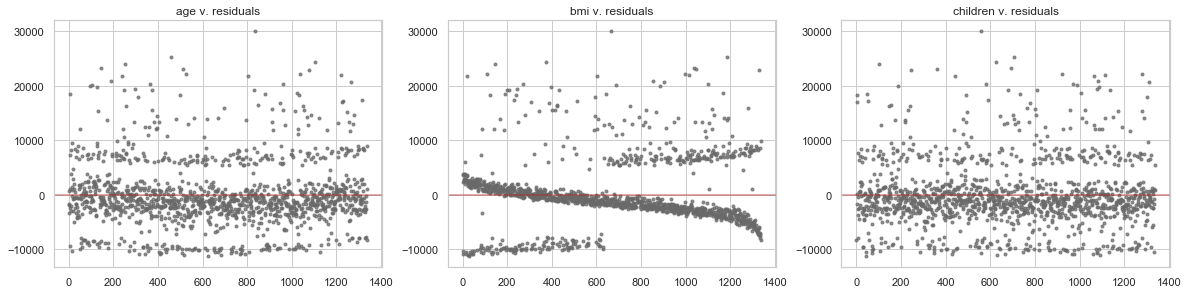

In [24]:
figure = plt.figure(figsize=(20,10))

variables = ["age", "bmi", "children"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( insurance[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

There are definitely patterns here. In age and children we see noticeable gaps above and below 0. For BMI there is a pretty straight line sloping down.

### Transformations

Because charges is money related it may make sense to take the log of it and use that instead.

In [25]:
#from the book
def log( x):
    return np.log(float( x))

In [26]:
insurance["log_charges"] = insurance["charges"].apply(log)

In [27]:
insurance["log_charges"].head()

0    9.734176
1    7.453302
2    8.400538
3    9.998092
4    8.260197
Name: log_charges, dtype: float64

With this new model, we will remove sex as it was not necessary from what we discovered. We will also use the log transformation for our target variable, charges.

In [28]:
model = "log_charges ~ age  + bmi + children + smoker + NE + NW + SE"
result = models.bootstrap_linear_regression(model, data=insurance)
display(models.describe_bootstrap_lr(result))

In [29]:
adjusted_r_squared(result)

0.7646959065378712

Both R^2s are slightly larger than the previous model. 

Are the residuals any better from the previous model?

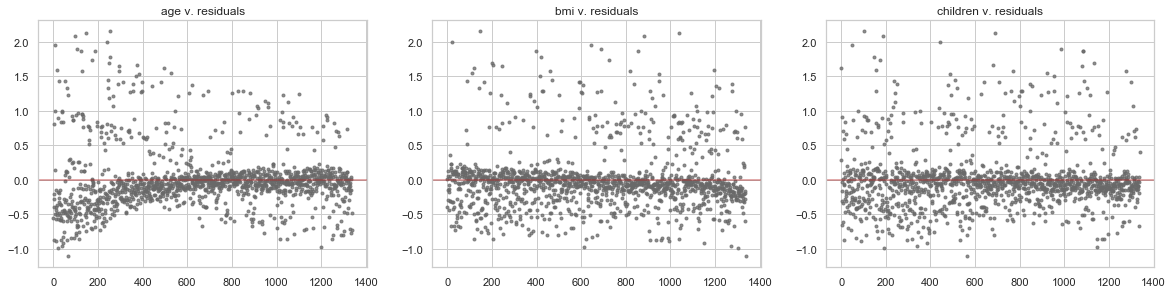

In [30]:
figure = plt.figure(figsize=(20,10))

variables = ["age", "bmi", "children"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( insurance[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

There is still some pattern especially in age and bmi with age getting more concentrated and BMI sloping downwards slightly. They are much better though.

### Multicollinearity

One thing I am starting to wonder about is if age and children have too much correlation with each other. I don't expect there to be that much but it is worth checking.

In [31]:
print("age v children = {0:.2f}".format(stats.pearsonr(insurance.age, insurance.children)[0]))

age v children = 0.04


That is very low so I can move on from that.

### Back to Models

We can also take the log of the rest of the variables in addition to charges except children since there's only 6 different values and the residuals look ok.

In [32]:
insurance["log_age"] = insurance["age"].apply(log)

In [33]:
insurance["log_bmi"] = insurance["bmi"].apply(log)

In [34]:
model = "log_charges ~ log_age  + log_bmi + children + smoker + NE + NW + SE"
result = models.bootstrap_linear_regression(model, data=insurance)
display(models.describe_bootstrap_lr(result))

In [35]:
adjusted_r_squared(result)

0.7657921599326221

The outcome was pretty much the same. But let's see what the residuals show.

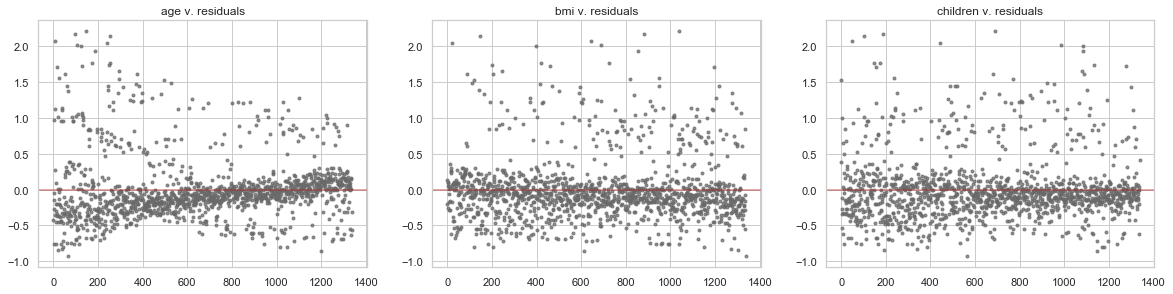

In [36]:
figure = plt.figure(figsize=(20,10))

variables = ["age", "bmi", "children"]
plots = len( variables)

rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( insurance[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

Age looks worse and bmi looks better. There still is the general lower concentration of the residuals.

I want to take a look at the specific relationship between Age and Charges some more.

In [37]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

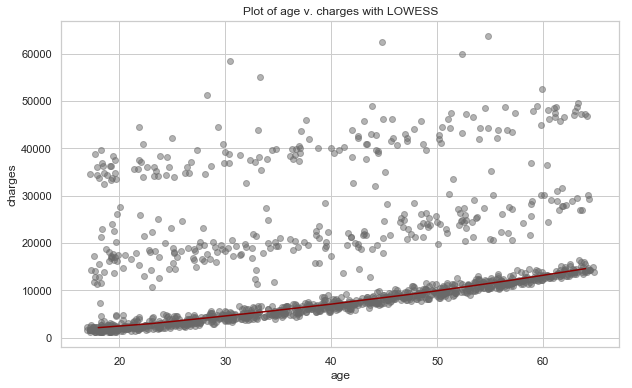

In [38]:
lowess_scatter(insurance, "age", "charges", jitter=0.01, skip_lowess=False)

It looks like there are three separate tiers for charges that all increase about the same as age increases. Otherwise it looks to be a very linear relationship.

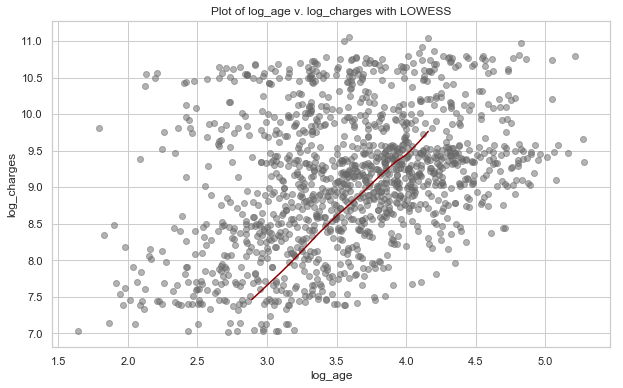

In [39]:
lowess_scatter(insurance, "log_age", "log_charges", jitter=0.01, skip_lowess=False)

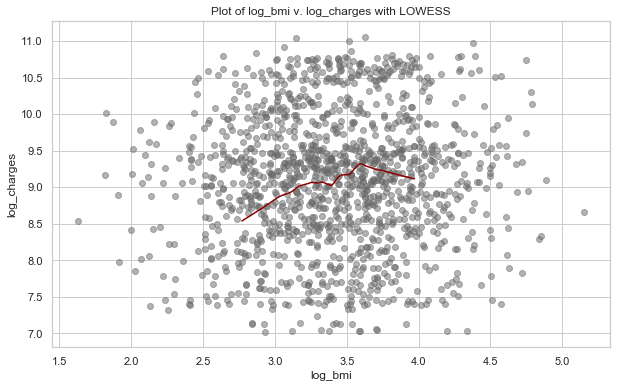

In [40]:
lowess_scatter(insurance, "log_bmi", "log_charges", jitter=0.01, skip_lowess=False)

Looking at the log relationship helps remove the tiered look of the data but it looks more like a blob than any real relationship.

Additionally, based on some further research from the following website (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/) the residuals are showing an unbalanced y-axis. This usually means two things. A missing variable (which could very well be the case here) or also a transformation that is required of the dependent variable (charges). Since log_charges was also showing this same residual result, we may need to transform it further.

Let's go back to the distribution of charges and its transformation as charges is not normal. I will plot the distribution of log_charges.

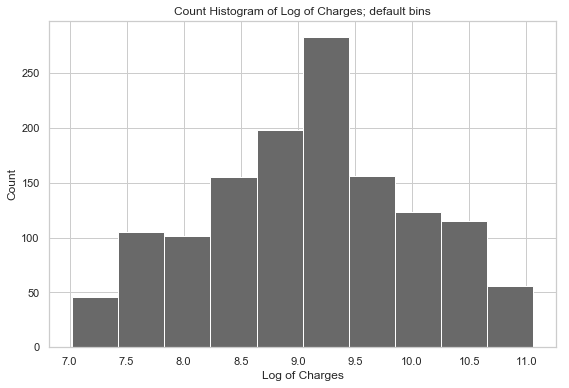

In [41]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( insurance[ "log_charges"], color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Log of Charges")
axes.set_title("Count Histogram of Log of Charges; default bins")

plt.show()
plt.close()

That distribution looks normal which is what we want. However, the residuals are still Y-axis unbalanced. The other reasoning for the residual shape is a missing variable. Let's go back to the model with just log_charges and the sex variable removed.

In [42]:
model = "log_charges ~ age + bmi + children + smoker + NE + NW + SE"
result = models.bootstrap_linear_regression(model, data=insurance)
display(models.describe_bootstrap_lr(result))

Let's look at our predictions to see how the model performs against them.

In [43]:
predictions = {"age": "+", "bmi": "+", "children": "+", "smoker": "+", "NE": "+", "NW": "+", "SE": "+"}
evaluate_coefficient_predictions(predictions, result)

age P(>0)=1.000
bmi P(>0)=1.000
children P(>0)=1.000
smoker P(>0)=1.000
NE P(>0)=1.000
NW P(>0)=0.980
SE P(>0)=0.260


Age, BMI, children, and smoker are all 100% positive. The region variables are interesting. The NE is positive and NW is most likely positive. However, SE is most likely negative. The difficult thing about the regions is that there was not much to go off of in regards to the relationship of the regions as I did not explore that relationship in Lab 5.

We had already viewed the residuals and they still were Y-axis unbalanced.